# Two Component Mixture
Suppose the data is composed of a number of different components.  The most natural way to describe it is to just define the components and choose a component for each data point.

In this example, we'll consider the simplest case - 2 components.  Data points live on the real axis, with two centers.

In [1]:
interp.repositories() ++= Seq(
    coursier.MavenRepository("https://dl.bintray.com/cibotech/public"),
    coursier.MavenRepository("https://dl.bintray.com/scala-infer/maven")
)

In [ ]:
import $ivy.`scala-infer::scala-infer:0.3-SNAPSHOT`
import $ivy.`com.cibo::evilplot-repl:0.6.3`
import $ivy.`com.cibo::evilplot-jupyter-scala:0.6.3`
import $ivy.`org.jupyter-scala::kernel-api:0.4.1`

In [ ]:
import com.cibo.evilplot._
import com.cibo.evilplot.colors._
import com.cibo.evilplot.geometry._
import com.cibo.evilplot.numeric._
import com.cibo.evilplot.plot._
import com.cibo.evilplot.plot.aesthetics.Theme
import com.cibo.evilplot.plot.aesthetics.DefaultTheme._
import com.cibo.evilplot.plot.renderers._

implicit class JupyterScalaDrawableMethods(drawable: Drawable) {
    def show: Unit = {
        val bi = drawable.asBufferedImage
        val baos = new java.io.ByteArrayOutputStream()
        javax.imageio.ImageIO.write(bi, "png", baos)
        val bytes = baos.toByteArray()
        kernel.publish.display(almond.interpreter.api.DisplayData.png(bytes))
    }
}

implicit class JupyterScalaPlotMethods(plot: Plot) {
    def show(implicit theme: Theme): Unit =
        plot.render()(theme).show
}

val colors = Color.getDefaultPaletteSeq(4).map { _.hsla.copy(opacity = 0.5)}
val renderer = new PointRenderer[Point3d[Int]] {
    
    def render(point: Point3d[Int]): Drawable = {
        Disc.centered(4).filled(colors(point.z))
    }

}

## Generate data
We generate the data we'll be fitting later by choosing two centers for a gaussian (at `-0.5` and `1.2`), with a common standard deviation (`0.25`).

The two components have an unequal part of the data; the first component (at `-0.5`) has 75% of the data points, the other component just 25%.

In [ ]:
import scala.util.Random

val data = {
    val p = 0.75
    val mu1 = -0.5
    val mu2 = 1.2
    val sigma = 0.25

    for {_ <- 0 until 500} yield {
        if (Random.nextDouble() < p) {
            Random.nextGaussian() * sigma + mu1
        } else {
            Random.nextGaussian() * sigma + mu2
        }
    }
}

## Plot the data

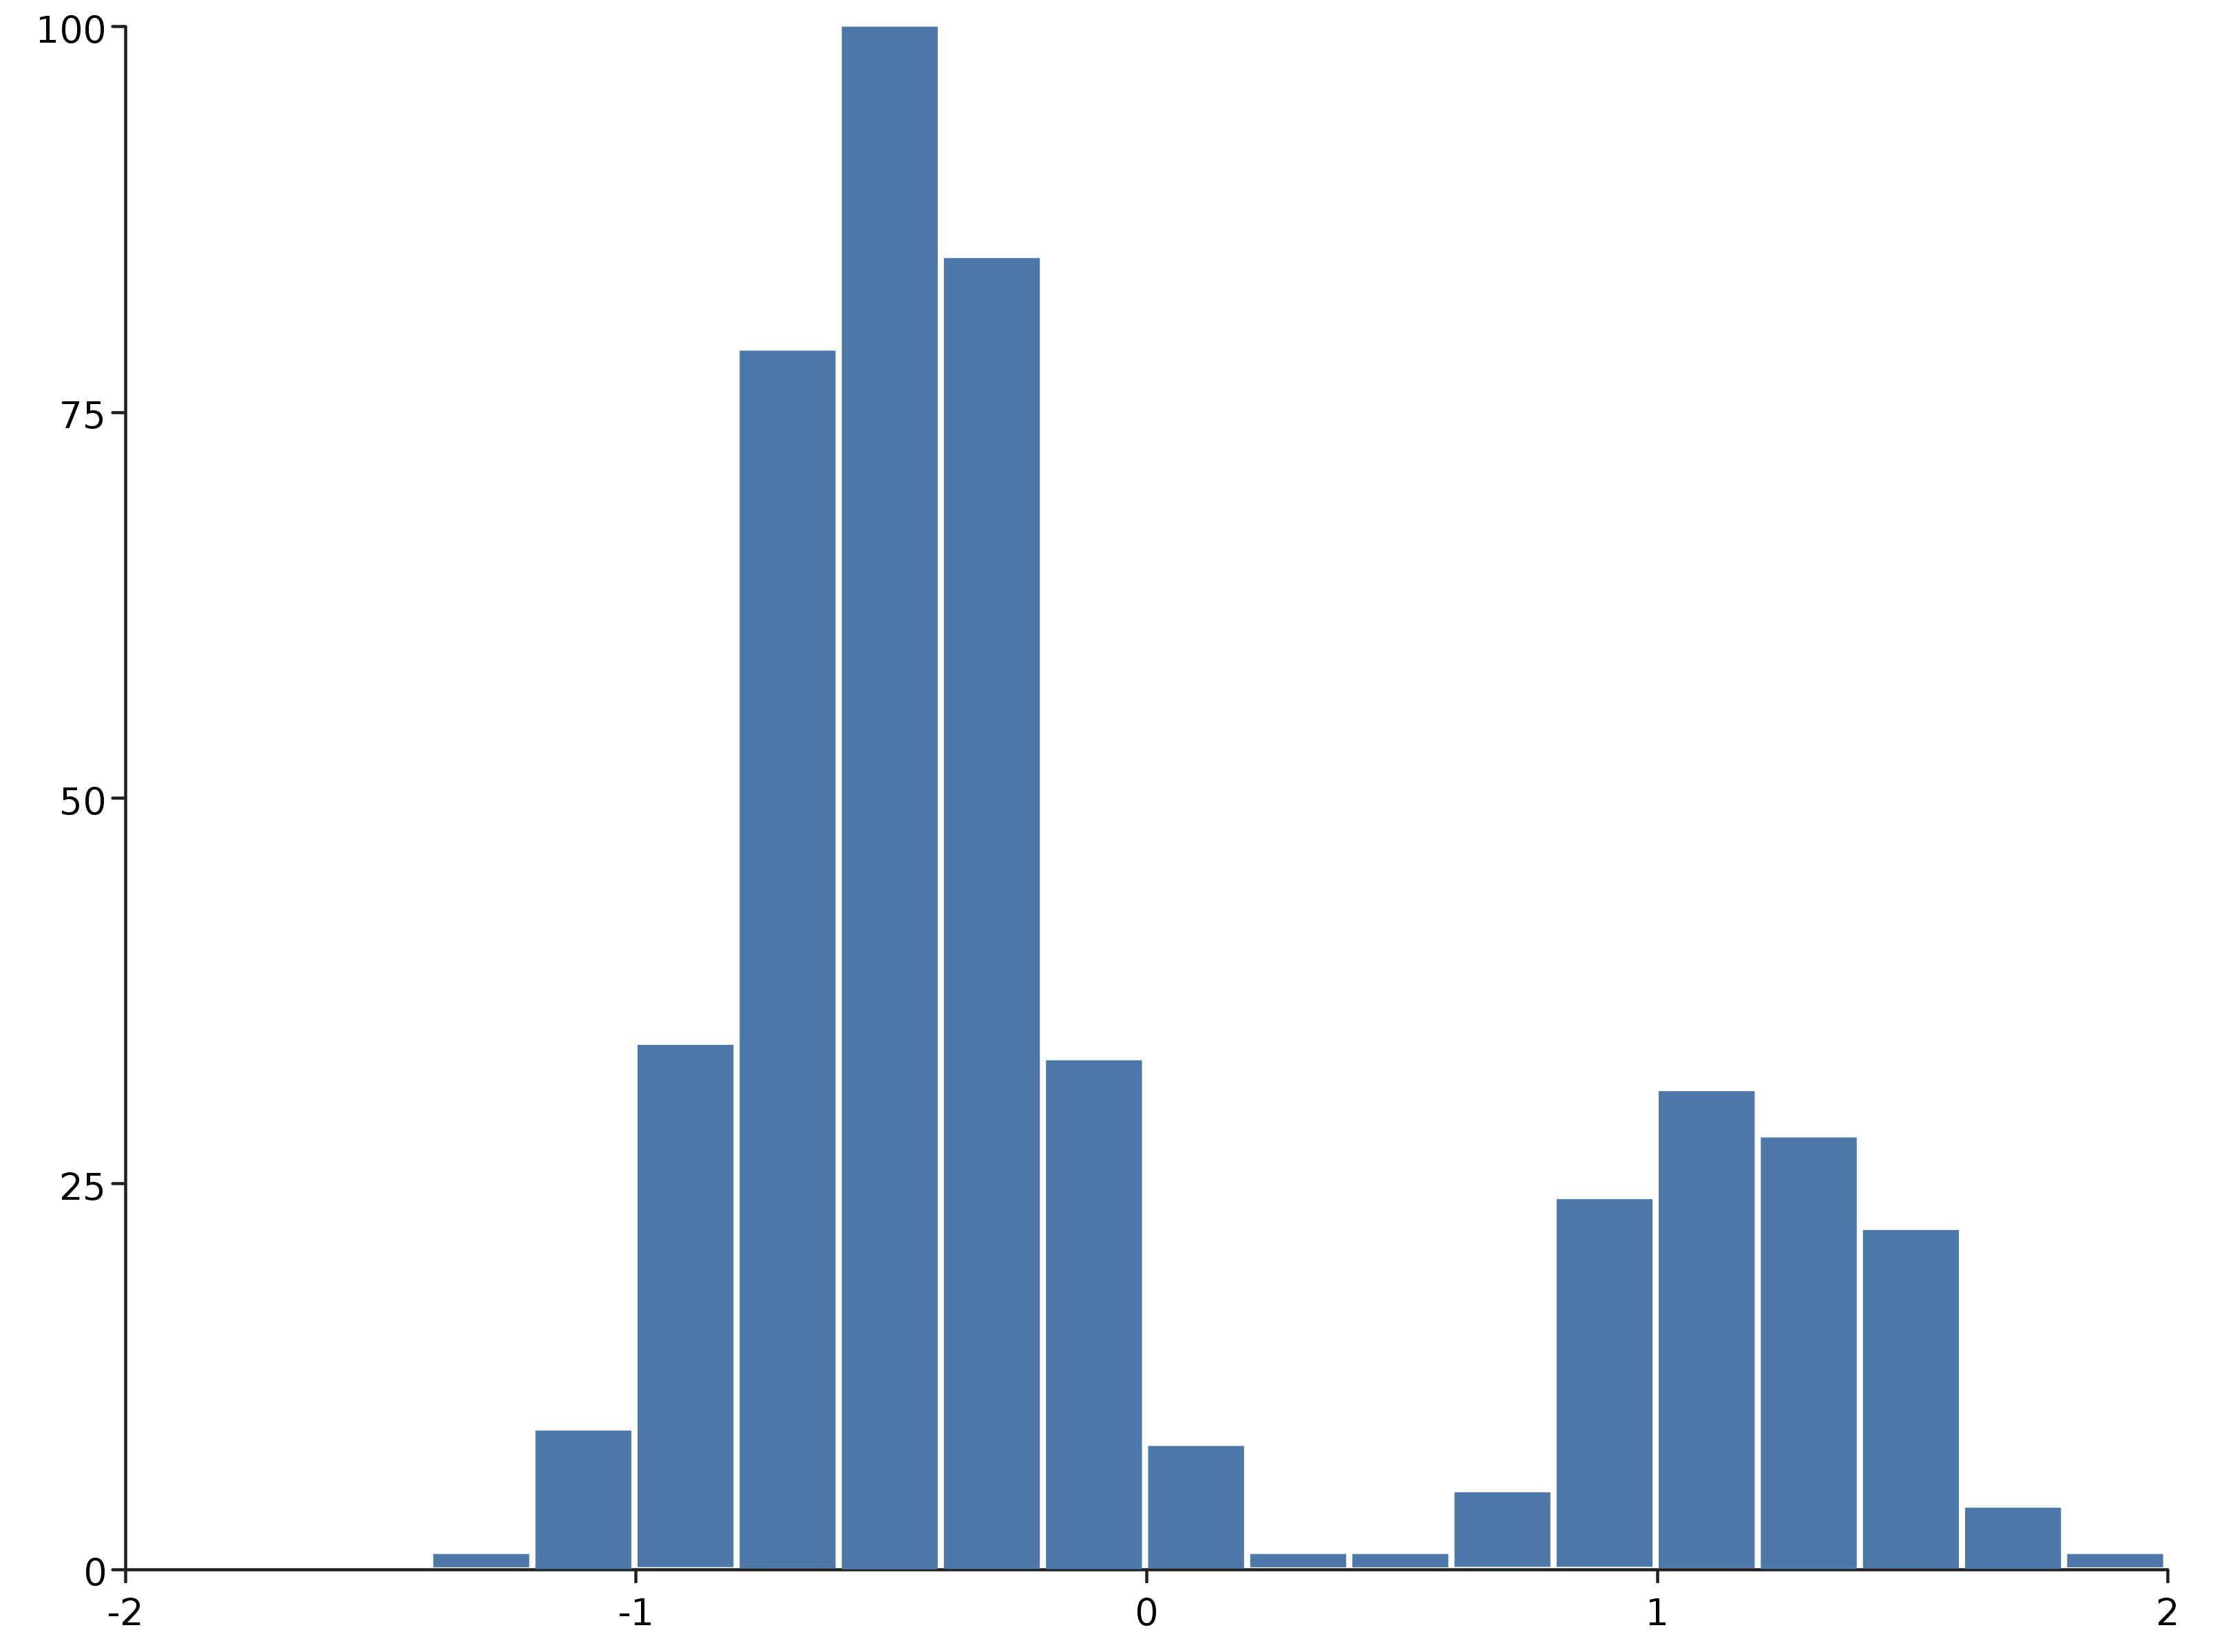

In [5]:
Histogram(data)
    .xAxis().yAxis()
    .frame()
    .show

## Guides for data points
Since each data point can come from either component, a discrete random variable determines which component to choose.

In [ ]:
import scappla.guides.BBVIGuide
import scappla.distributions.Bernoulli
import scappla.Functions.sigmoid
import scappla.optimization.Adam

val sgd = new Adam(0.1)

val dataWithDist = data.map { datum =>
    val param = sgd.param(0.0)
    (datum, BBVIGuide(Bernoulli(sigmoid(param))))
}

## Define the model
For each of the parameters, we define a guide to the posterior.  To break the symmetry between the components, we initialize the guides at different centers.

In [ ]:
import scappla.{infer, sample, observe, Real}
import scappla.guides.ReparamGuide
import scappla.distributions.Normal
import scappla.Functions.exp

val pPost = ReparamGuide(Normal(
    sgd.param(0.0), exp(sgd.param(0.0))
))
val mu1Post = ReparamGuide(Normal(
    sgd.param(-1.0), exp(sgd.param(0.0))
))
val mu2Post = ReparamGuide(Normal(
    sgd.param(1.0), exp(sgd.param(0.0))
))
val sigmaPost = ReparamGuide(Normal(
    sgd.param(0.0), exp(sgd.param(0.0))
))

val model = infer {
    val p = sigmoid(sample(Normal(0.0, 1.0), pPost))
    val mu1 = sample(Normal(0.0, 1.0), mu1Post)
    val mu2 = sample(Normal(0.0, 1.0), mu2Post)
    val sigma = exp(sample(Normal(0.0, 1.0), sigmaPost))

    dataWithDist.foreach[Unit] {
        case (value, guide) =>
            if (sample(Bernoulli(p), guide)) {
                observe(Normal(mu1, sigma), value: Real)
            } else {
                observe(Normal(mu2, sigma), value: Real)
            }
    }

    (p, mu1, mu2, sigma)
}


## Do the inference
By drawing samples, we train the model (i.e. learn the parameters of the variational approximation to the posterior).

In [ ]:
case class Sample(p: Double, mu1: Double, mu2: Double, sigma: Double)

val samples = for { _ <- 0 until 10000 } yield {
    val (p, mu1, mu2, sigma) = model.sample()
    Sample(p.v, mu1.v, mu2.v, sigma.v)
}

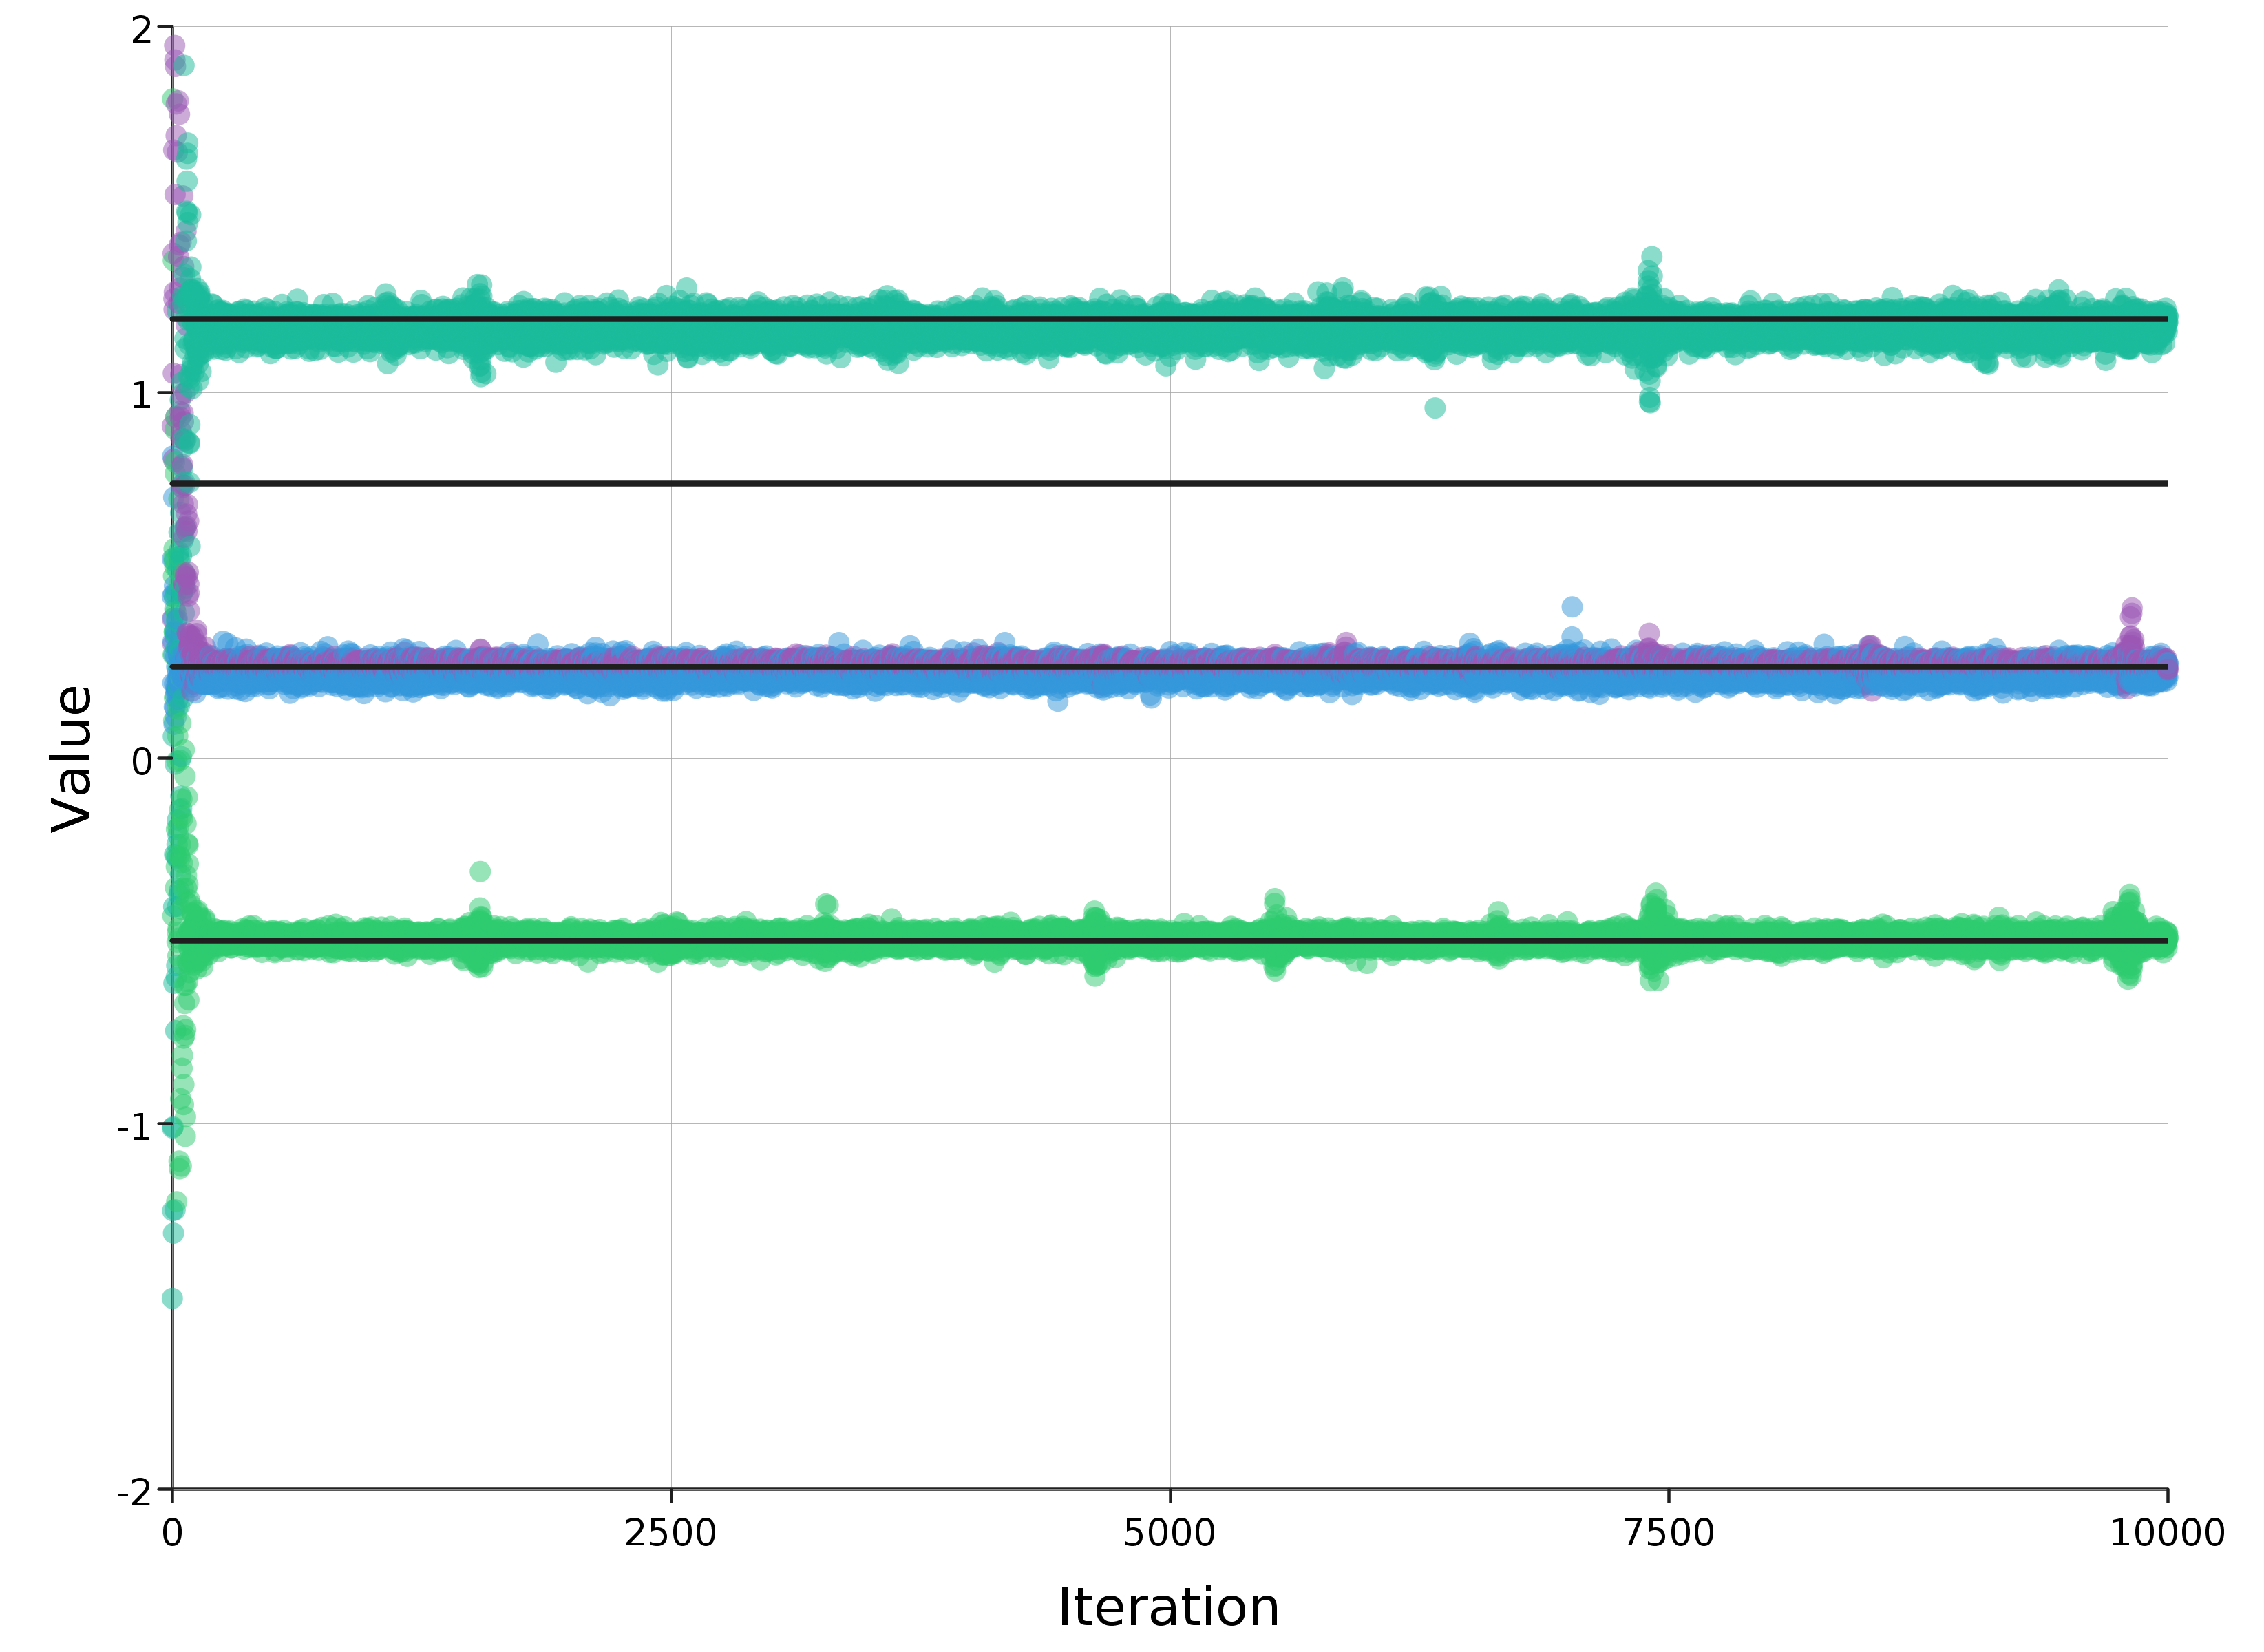

In [56]:
{{
    val points = samples.zipWithIndex.flatMap { case (sample, i) =>
        Seq(
            Point3d[Int](i, sample.mu1, 0),
            Point3d[Int](i, sample.mu2, 1),
            Point3d[Int](i, sample.p, 2),
            Point3d[Int](i, sample.sigma, 3)
        )
    }
    ScatterPlot(
        points,
        pointRenderer = Some(renderer)
    ).frame()
    .xAxis().xLabel("Iteration")
    .yAxis().yLabel("Value")
    .xGrid().yGrid()
    .ybounds(Bounds(-2, 2))
    .hline(0.25).hline(0.75).hline(1.2).hline(-0.5)
    .rightLegend()
    .show
}}

## Cluster assignments

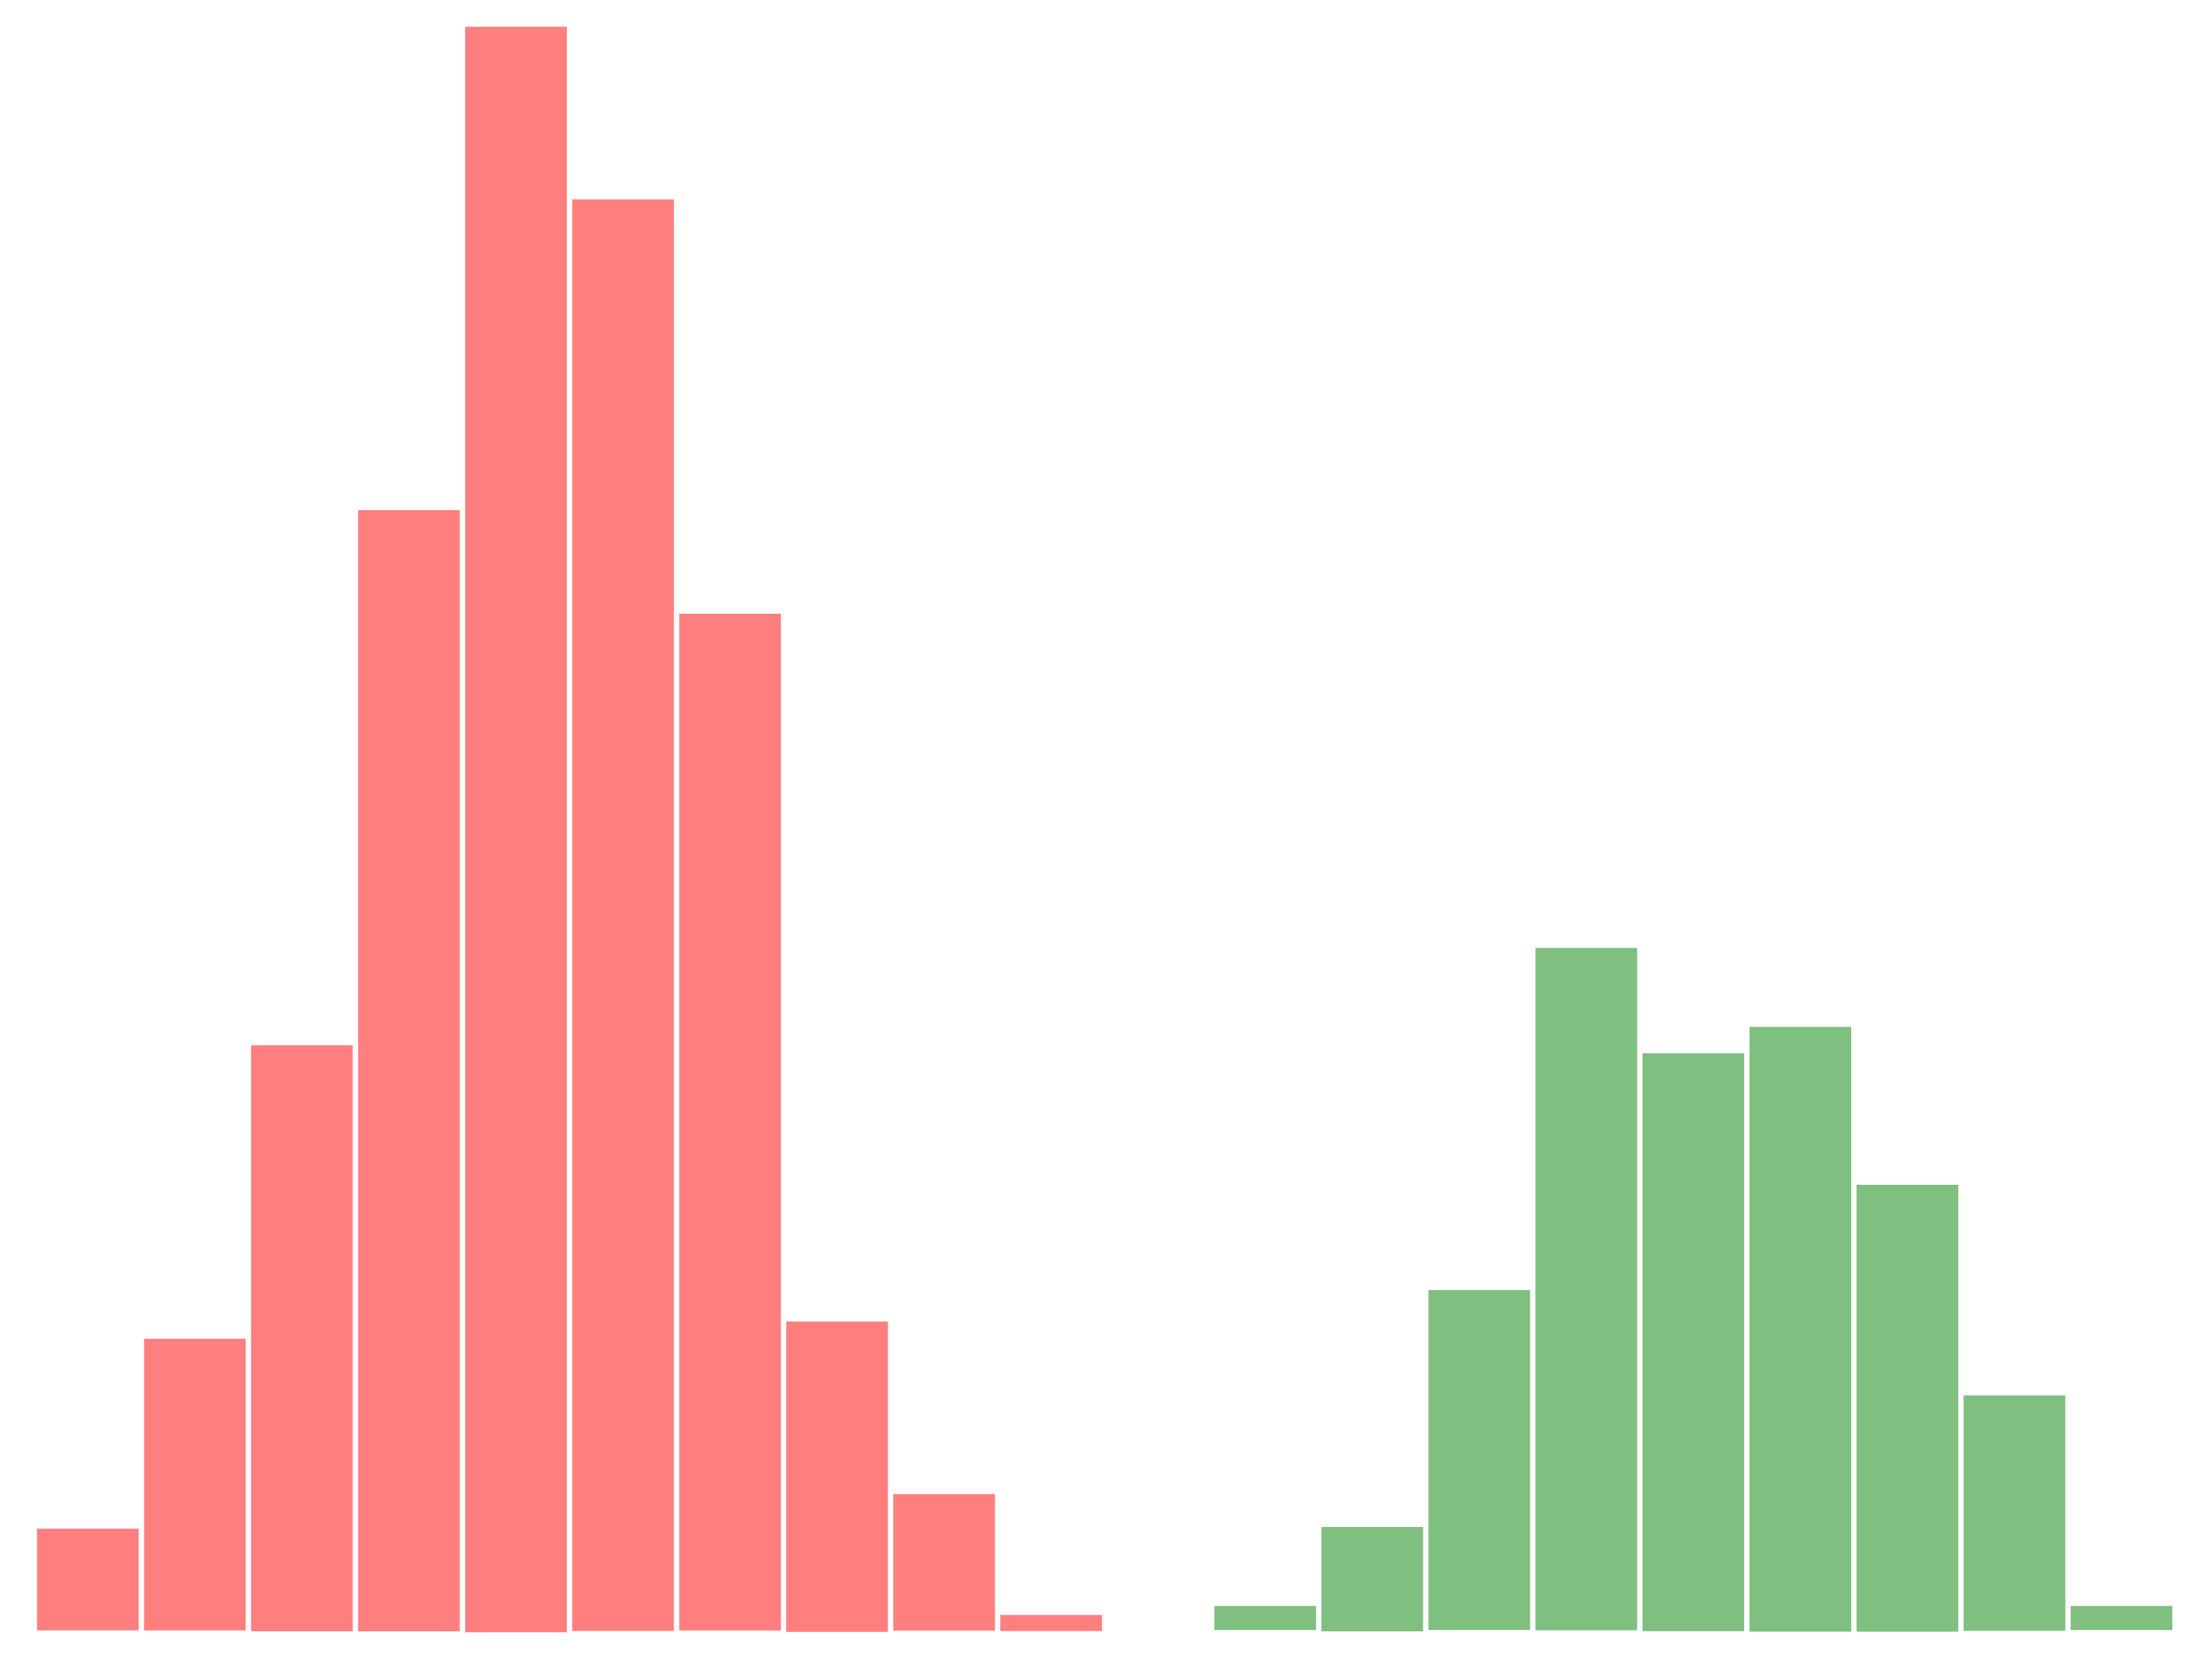

In [57]:
{{
    import com.cibo.evilplot.colors.HTMLNamedColors.{green, red}
    
    val assignments = dataWithDist.map {
        case (value, guide) =>
            (value, sample(Bernoulli(0.5), guide))
    }
    val components = assignments.groupBy{ _._2 }.mapValues { _.map { _._1 } }
    Overlay(
        Histogram(
            components(false),
            barRenderer = Some(BarRenderer.default(Some(red.copy(opacity = 0.5))))
        ),
        Histogram(
            components(true),
            barRenderer = Some(BarRenderer.default(Some(green.copy(opacity = 0.5))))
        )
    )
    .show
}}

# Amortized inference
Instead of learning a separate parameter for each data point for the component assignment, we can also postulate a function from data point to parameter value.  In this way, we only need to learn the parameters of the function.  When a new data point is encountered, inference just boils down to evaluating the function.

In [ ]:
val intercept = sgd.param(0.0).buffer
intercept.complete()
val slope = sgd.param(1.0).buffer
slope.complete()

val dataWithDist = data.map { datum =>
    import scappla.InferField._
    val local = intercept + slope * datum
    (datum, BBVIGuide(Bernoulli(sigmoid(local))))
}

// FIXME: This causes null-pointer in ammonite.  WHY???
// val sgd = new Adam(0.1)

val pPost = ReparamGuide(Normal(
    sgd.param(0.0), exp(sgd.param(0.0))
))
val mu1Post = ReparamGuide(Normal(
    sgd.param(-1.0), exp(sgd.param(0.0))
))
val mu2Post = ReparamGuide(Normal(
    sgd.param(1.0), exp(sgd.param(0.0))
))
val sigmaPost = ReparamGuide(Normal(
    sgd.param(0.0), exp(sgd.param(0.0))
))
val amortized = infer {
    val p = sigmoid(sample(Normal(0.0, 1.0), pPost))
    val mu1 = sample(Normal(0.0, 1.0), mu1Post)
    val mu2 = sample(Normal(0.0, 1.0), mu2Post)
    val sigma = exp(sample(Normal(0.0, 1.0), sigmaPost))

    dataWithDist.foreach[Unit] {
        case (value, guide) =>
            if (sample(Bernoulli(p), guide)) {
                observe(Normal(mu1, sigma), value: Real)
            } else {
                observe(Normal(mu2, sigma), value: Real)
            }
    }

    (p, mu1, mu2, sigma)
}

In [ ]:
case class Sample(p: Double, mu1: Double, mu2: Double, sigma: Double)

val startTime = System.currentTimeMillis()
val samples = for { _ <- 0 until 10000 } yield {
    intercept.buffer
    slope.buffer
    val (p, mu1, mu2, sigma) = amortized.sample()
    intercept.complete()
    slope.complete()
    Sample(p.v, mu1.v, mu2.v, sigma.v)
}
val endTime = System.currentTimeMillis()

println(s"Time / sample: ${((endTime - startTime) * 1000) / samples.size}mus")

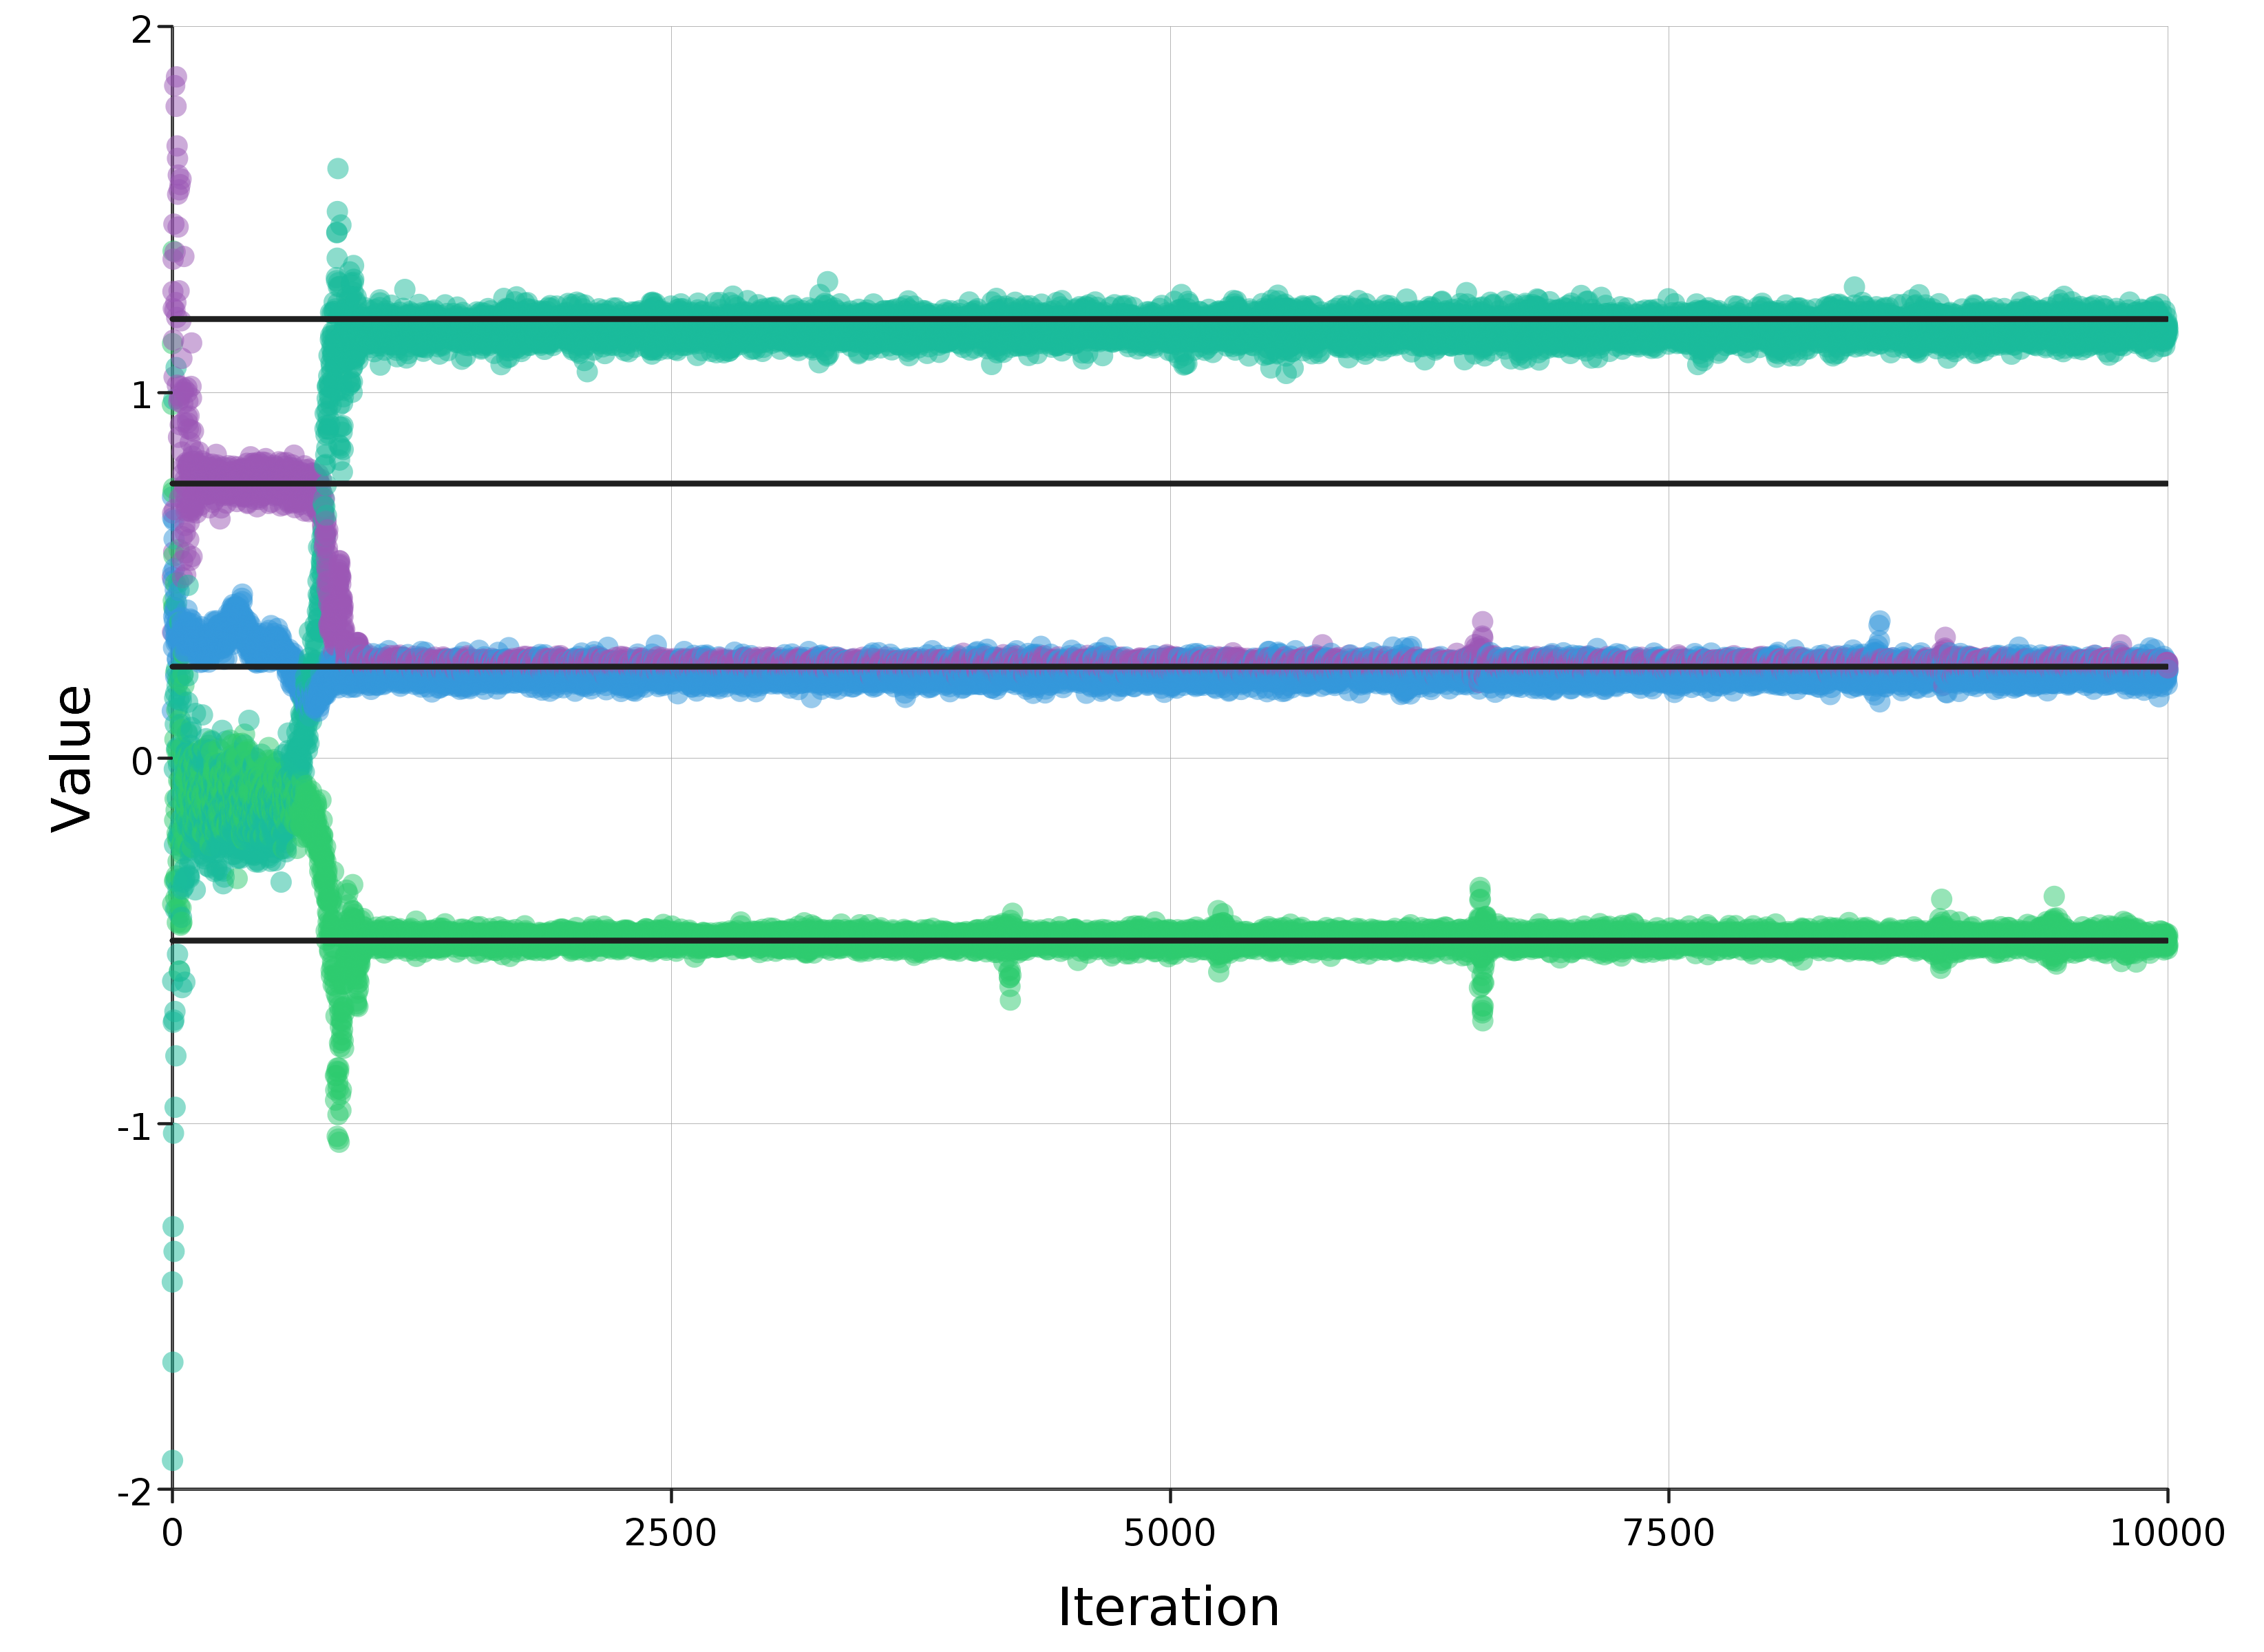

In [52]:
{{
    val points = samples.zipWithIndex.flatMap { case (sample, i) =>
        Seq(
            Point3d[Int](i, sample.mu1, 0),
            Point3d[Int](i, sample.mu2, 1),
            Point3d[Int](i, sample.p, 2),
            Point3d[Int](i, sample.sigma, 3)
        )
    }
    ScatterPlot(
        points,
        pointRenderer = Some(renderer)
    )
    .frame()
    .xAxis().xLabel("Iteration")
    .yAxis().yLabel("Value")
    .xGrid().yGrid()
    .ybounds(Bounds(-2, 2))
    .hline(0.25).hline(0.75).hline(1.2).hline(-0.5)
    .rightLegend()
    .show
}}